<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural

## Ejercicio

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy para servicios médicos.

### 1 - Instalar dependencias

In [91]:
#! pip install -U spacy==3.1 --quiet
#! pip install -U spacy-stanza==1.0.0 --quiet
#! pip install -U matplotlib seaborn --quiet

In [92]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [93]:
import stanza
import spacy_stanza

stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2023-05-10 21:46:56 INFO: Downloading default packages for language: es (Spanish)...
2023-05-10 21:46:56 INFO: File exists: C:\Users\jonat\stanza_resources\es\default.zip.
2023-05-10 21:46:59 INFO: Finished downloading models and saved to C:\Users\jonat\stanza_resources.
2023-05-10 21:46:59 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2023-05-10 21:46:59 INFO: Use device: cpu
2023-05-10 21:46:59 INFO: Loading: tokenize
2023-05-10 21:46:59 INFO: Loading: mwt
2023-05-10 21:46:59 INFO: Loading: pos
2023-05-10 21:46:59 INFO: Loading: lemma
2023-05-10 21:46:59 INFO: Loading: depparse
2023-05-10 21:46:59 INFO: Loading: ner
2023-05-10 21:47:00 INFO: Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [94]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [95]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
              "responses": ["Hola, ¿Cómo puedo asistirte hoy?", "¡Hola! ¿Qué necesitas hoy?"]
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es DoctorPro", "Yo soy DoctorPro"]
             },
             {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Puedes contactarnos al siguiente número: <número>", "Para WhatsApp, contáctanos en <número>"]
             },
             {"tag": "turnos",
              "patterns": ["Quiero tomar un turno", "Necesito un turno", "¿Cómo puedo reservar un turno?"],
              "responses": ["Puedes reservar un turno en este <link>", "Para tomar un turno, por favor visita este <link>"]
             },
             {"tag": "horarios",
              "patterns": ["¿Cuáles son los horarios de atención?", "¿A qué hora abren?", "¿A qué hora cierran?"],
              "responses": ["Nuestros horarios de atención son de 9 a 19hs de lunes a viernes", "Estamos abiertos de 9 a 19hs de lunes a viernes"]
             },
             {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["Aceptamos diversas formas de pago, puedes encontrar más detalles en este <link>"]
             },
             {"tag": "teleconsulta",
              "patterns": ["¿Puedo hacer una teleconsulta?", "¿Ofrecen consultas en línea?", "¿Cómo puedo hacer una consulta en línea?"],
              "responses": ["Sí, ofrecemos teleconsultas. Puedes reservar una en este <link>"]
             },
             {"tag": "agradecimientos",
              "patterns": ["Muchas gracias", "Gracias"],
              "responses": ["¡De nada! Si tienes cualquier otra pregunta, no dudes en preguntar."]
             },
             {"tag": "despedida",
              "patterns": ["Chau", "Hasta luego!"],
              "responses": ["¡Hasta luego!", "¡Hablamos luego!"]
             }
]}


### 4 - Preprocesamiento y armado del dataset

In [96]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [97]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'abrir', 'atencion', 'cerrar', 'chau', 'como', 'consulta', 'contacto', 'credito', 'cual', 'cuota', 'de', 'el', 'en', 'este', 'gracias', 'hacer', 'hasta', 'holar', 'hora', 'horario', 'linea', 'luego', 'medio', 'mucho', 'necesitar', 'nombre', 'numero', 'ofrecer', 'pago', 'poder', 'que', 'querer', 'quien', 'reservar', 'ser', 'tal', 'tarjeta', 'teleconsulta', 'telefono', 'tomar', 'tu', 'turno', 'uno', 'whatsapp']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'despedida', 'horarios', 'nombre', 'pagos', 'teleconsulta', 'turnos']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', 'Quiero tomar un turno', 'Necesito un turno', '¿Cómo puedo reservar un turno?', '¿Cuáles son los horarios de atención?', '¿A qué hora abren?', '¿A qué hora cierran?', 'medios de pago', 'tarjeta de crédito', 'tarjetas', 'cuotas', '¿Puedo hacer una teleconsulta?', '¿Ofrecen con

In [98]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 45


In [99]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [100]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1

### 5 - Entrenamiento del modelo

In [101]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (45,) output: 9


In [102]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               5888      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 9)                 585       
                                                                 
Total params: 14,729
Trainable params: 14,729
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 490ms/step - loss: 2.3307 - accuracy: 0.0370
Epoch 2/200
1/1 [==============================] - 0s 4ms/step - loss: 2.2604 - accuracy: 0.0370
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 2.2403 - accuracy: 0.0741
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 2.2203 - accuracy: 0.0741
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1707 - accuracy: 0.1111
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 2.0914 - accuracy: 0.2222
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1785 - accuracy: 0.1852
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1829 - accuracy: 0.1111
Epoch 9/200
1/1 [==============================] - 0s 4ms/step - loss: 2.1009 - accuracy: 0.1852
Epoch 10/200
1/1 [==============================] - 0s 3ms/step - loss: 2.0313 - accuracy: 0.4074
Epoch 11/200
1/1 [=========

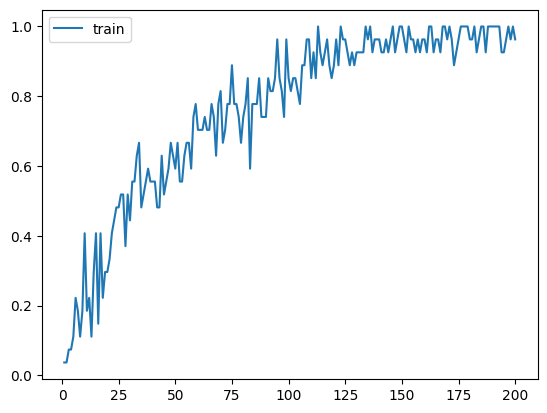

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [105]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [106]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [107]:
# Permitimos 5 iteraciones
for i in range(5):
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: Hola! necesito ayuda
1/1 [==============================] - 0s 44ms/step
BOT: Hola, ¿Cómo puedo asistirte hoy?
Q: Quiero sacar un turno por favor
1/1 [==============================] - 0s 13ms/step
BOT: Para tomar un turno, por favor visita este <link>
Q: a
1/1 [==============================] - 0s 16ms/step
BOT: Estamos abiertos de 9 a 19hs de lunes a viernes
Q: tu
1/1 [==============================] - 0s 17ms/step
BOT: Perdón, no comprendo la pregunta.
Q: chau
1/1 [==============================] - 0s 18ms/step
BOT: ¡Hablamos luego!


# Conclusiones de la primera parte

### Notese el error en la respuesta de la pregunta 3:

```
Q: a
1/1 [==============================] - 0s 16ms/step
BOT: Estamos abiertos de 9 a 19hs de lunes a viernes
```

Esto se podría mejorar si se filtra los stop words.

El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

# Hacemos ensayos comparando ahora un modelo utilizando filtrado de _stop words_ y TF-IDF

In [108]:
# ! pip install scikit-learn

In [304]:
import math
import spacy

# Define stop_words from spacy
stop_words = spacy.lang.es.stop_words.STOP_WORDS

# Probamos utilizar un filtro para los stop words
def filter_stop_words(text):
    tokens = []
    for token in text:
        if token not in stop_words:
            tokens.append(token)
    return tokens

# Redefinimos la función de preprocesamiento
def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    # quitar stopwords
    text = ' '.join(filter_stop_words(text.split()))
    return text

def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def term_frequency(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] += 1
    #print(bow)
    return np.array(bow)

def idf(corpus_terms, vocab):
    # Crear un vector de ceros con longitud igual a la longitud del vocabulario (número de términos únicos)
    idf_vector = np.zeros((len(vocab), ))

    n = len(corpus_terms)

    # Para cada término en el vocabulario
    for i, term in enumerate(vocab):
        # Calcula cuántos documentos contienen el término
        df_t = sum([term in doc for doc in corpus_terms])
        # Verificar si df_t es igual a cero
        if df_t == 0:
            # Si es cero, establecer el valor IDF en cero o el valor mínimo posible
            idf_vector[i] = 0
        else:
            # Si no es cero, calcular el IDF del término
            idf_vector[i] = math.log(n / df_t)
        
    return idf_vector


def get_tfidf(text, vocab):
    # Transformar cada documento en una lista de términos
    tokens = text_to_tokens(text)

    # Calcular la matriz de Frecuencia de Término (TF)
    tf_matrix = term_frequency(text, vocab)

    # Calcular el vector de Frecuencia Inversa de Documento (IDF)
    idf_vector = idf(tokens, vocab)

    # Multiplicar la matriz TF por el vector IDF para obtener la matriz TF-IDF
    tfidf_matrix = tf_matrix * idf_vector

    return tfidf_matrix

# usar modelo con la entrada en TF-IDF y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    tfidf = get_tfidf(text, vocab)
    # Collect booleans in an array for each element in tfidf > 0
    words_recognized = tfidf > 0

    return_list = []

    if words_recognized.any(): # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([tfidf]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

### Volvemos a entrenar el modelo con las modificaciones y evaluamos los resultados.

In [305]:
words = []
classes = []
doc_X = []
doc_y = []

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [306]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['abrir', 'atencear', 'cerrar', 'chau', 'consulta', 'contacto', 'credito', 'cuota', 'gracias', 'holar', 'hora', 'horario', 'lineo', 'medio', 'necesitar', 'nombre', 'numerar', 'numero', 'ofrecer', 'pago', 'querer', 'reservar', 'ser', 'tarjeta', 'teleconsulta', 'telefono', 'tomar', 'turno', 'whatsapp']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'despedida', 'horarios', 'nombre', 'pagos', 'teleconsulta', 'turnos']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Cúal es tu nombre?', '¿Quién sos?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', 'Quiero tomar un turno', 'Necesito un turno', '¿Cómo puedo reservar un turno?', '¿Cuáles son los horarios de atención?', '¿A qué hora abren?', '¿A qué hora cierran?', 'medios de pago', 'tarjeta de crédito', 'tarjetas', 'cuotas', '¿Puedo hacer una teleconsulta?', '¿Ofrecen consultas en línea?', '¿Cómo puedo hacer una consulta en línea?', 'Muchas gracias', 'Gracias', 'Chau', 'Hasta luego!']
d

In [307]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 29


In [308]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [309]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0,

In [310]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (29,) output: 9


In [311]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 128)               3840      
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 dense_65 (Dense)            (None, 9)                 585       
                                                                 
Total params: 12,681
Trainable params: 12,681
Non-trainable params: 0
_________________________________________________________________
None


In [312]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 0s 480ms/step - loss: 2.2474 - accuracy: 0.1111
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 2.2252 - accuracy: 0.1481
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1911 - accuracy: 0.1481
Epoch 4/200
1/1 [==============================] - 0s 4ms/step - loss: 2.2287 - accuracy: 0.1111
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 2.1517 - accuracy: 0.0741
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1319 - accuracy: 0.1111
Epoch 7/200
1/1 [==============================] - 0s 3ms/step - loss: 2.2220 - accuracy: 0.0741
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1820 - accuracy: 0.1481
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1392 - accuracy: 0.0741
Epoch 10/200
1/1 [==============================] - 0s 4ms/step - loss: 2.1488 - accuracy: 0.2222
Epoch 11/200
1/1 [=========

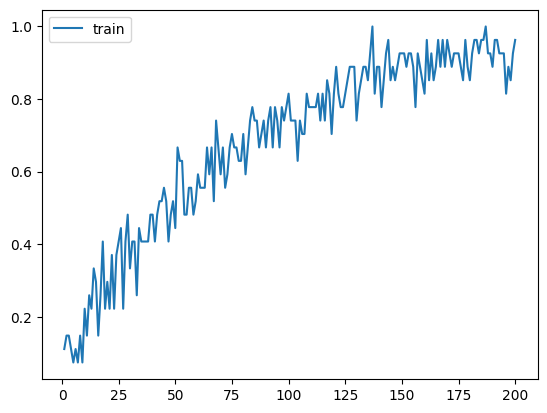

In [313]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [314]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model_v2.h5')

In [315]:
# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

In [316]:
# Permitimos 5 iteraciones
for i in range(5):
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Q: Hola! necesito ayuda
1/1 [==============================] - 0s 37ms/step
BOT: ¡Hola! ¿Qué necesitas hoy?
Q: Quiero sacar un turno por favor
1/1 [==============================] - 0s 14ms/step
BOT: Puedes reservar un turno en este <link>
Q: a
BOT: Perdón, no comprendo la pregunta.
Q: chau
BOT: Perdón, no comprendo la pregunta.
Q: chau, nos vemos!
1/1 [==============================] - 0s 17ms/step
BOT: ¡Hablamos luego!


# Conclusiones finales

* Se logró un rendimiento similar al modelo original al aplicar filtrado de _stop words_, pero con un vocabulario más reducido.
* La eliminación de _stop words_ puede mejorar la calidad de la representación de los documentos al reducir el ruido en los datos pero tenemos que tener cuidado de no eliminar palabras que aporten información relevante.
* El uso de la representación TF-IDF puede mejorar el rendimiento de los modelos de procesamiento de texto al encontrar patrones más distintivos en el contenido de los documentos, pero puede afectar negativamente en algunos casos. Para el caso de preguntas cortas con palabras que están presentes en el vocabulario como en el ejemplo anterior en la pregunta 4: "chau". En cambio si le agregamos más palabras significativas al texto de entrada, el TF-IDF calculado será distinto de cero y podrá hacer la inferencia correctamente.
* Algunas palabras del vocabulario que surgieron de la lematización no forman parte del idioma español, por lo que ensucian los datos de entrenamiento y pueden afectar el rendimiento del modelo al aprender palabras que no existen.